In [1]:
# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for modeling, evaluation, and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Imbalanced-learn for SMOTE
from imblearn.over_sampling import SMOTE

# Kagglehub for dataset download
import kagglehub

# Set plot style for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)


c:\Users\shiva\OneDrive\Desktop\assignment-3-shivan-21\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download and Save Data

In [2]:

# --- Data Download ---
print("Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
# save the dataset for future use
csv_file_path = os.path.join(path, 'creditcard.csv')

# Load the dataset
df = pd.read_csv(csv_file_path)

print("\nDataset loaded successfully!")
print(df.head())


Dataset loaded successfully!
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

  

# Analyse the data and Determine and Class Distribution


Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage of non-fraudulent (0): 99.8273%
Percentage of fraudulent (1): 0.1727%


C:\Users\shiva\AppData\Local\Temp\ipykernel_29388\2009047173.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, ax=axes[0], palette=['skyblue', 'orange'])


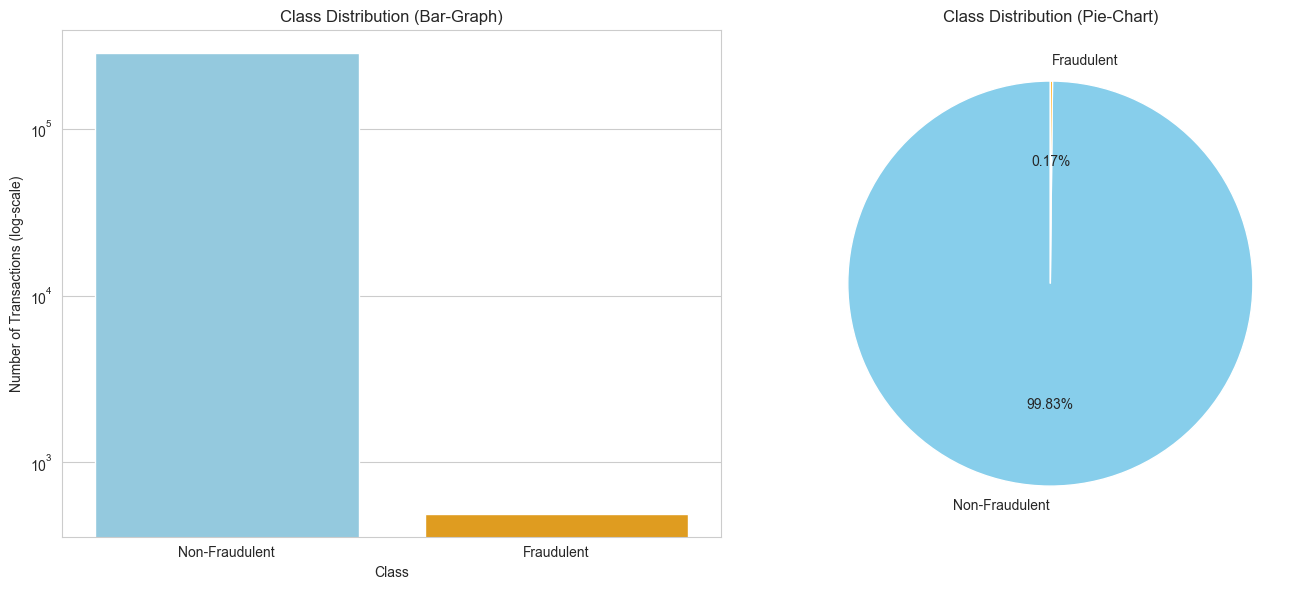

In [3]:
# Get class distribution
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(class_counts)
print(f"\nPercentage of non-fraudulent (0): {class_percentages[0]:.4f}%")
print(f"Percentage of fraudulent (1): {class_percentages[1]:.4f}%")

# Visualize the distribution with bar and pie chart side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
# Bar chart
sns.countplot(x='Class', data=df, ax=axes[0], palette=['skyblue', 'orange'])
axes[0].set_title('Class Distribution (Bar-Graph)')
axes[0].set_ylabel('Number of Transactions (log-scale)')
axes[0].set_xlabel('Class')
axes[0].set_yscale('log')  # Log scale for better visibility
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Fraudulent', 'Fraudulent'])
# Pie chart
axes[1].pie(class_counts, labels=['Non-Fraudulent', 'Fraudulent'], autopct='%1.2f%%', colors=['skyblue', 'orange'], startangle=90)
axes[1].set_title('Class Distribution (Pie-Chart)')

plt.tight_layout()

# Scale the Features of the Data
- perform test train split

In [4]:
# The 'Class' column is our target variable
X = df.drop('Class', axis=1)
y = df['Class']

# 1. Split the data into training and testing sets (80/20)
# Use stratify to maintain the same class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Scale the features
# We only scale the 'Amount' and 'Time' columns as V1-V28 are already scaled (from PCA)
scaler = StandardScaler()

# Create copies to avoid SettingWithCopyWarning
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit the scaler ONLY on the training data
scaler.fit(X_train[['Time', 'Amount']])

# Transform both the training and test data using the fitted scaler
X_train_scaled[['Time', 'Amount']] = scaler.transform(X_train[['Time', 'Amount']])
X_test_scaled[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

print("Data successfully split and scaled without leakage.")
print("Shape of scaled training data:", X_train_scaled.shape)
print("Shape of scaled testing data:", X_test_scaled.shape)

Data successfully split and scaled without leakage.
Shape of scaled training data: (227845, 30)
Shape of scaled testing data: (56962, 30)


# Accuracy is a Poor Predictor of a Models Performance for Imbalanced Data
>> Explanation of why this is So
>> Precisison and Recall are robust measures

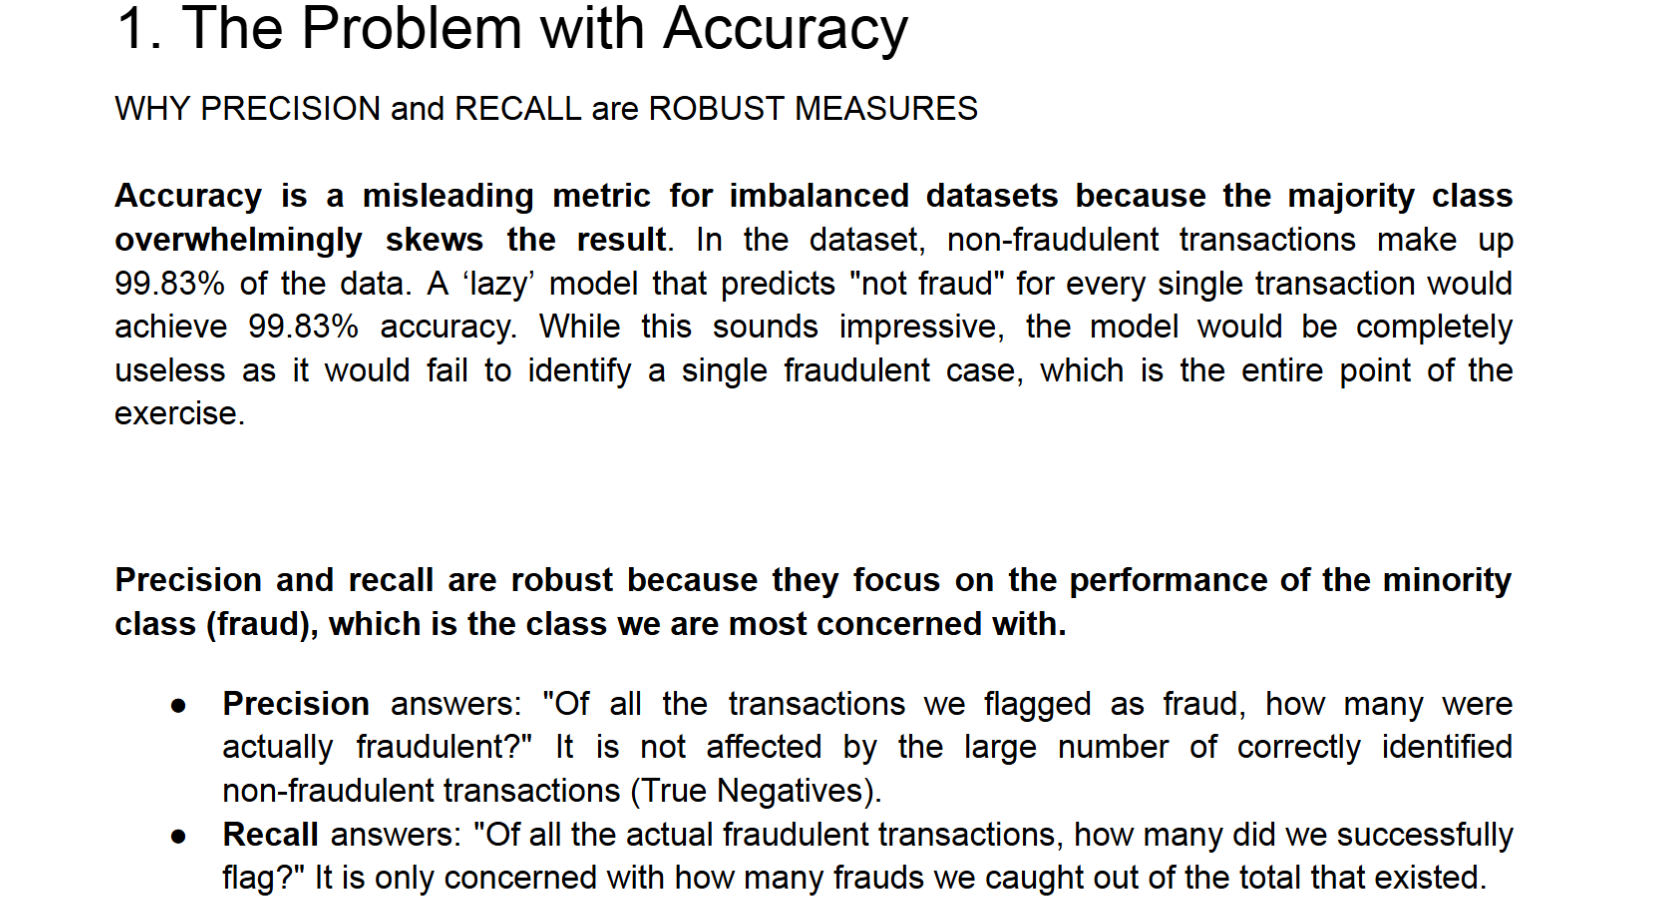

# Find the optimum number of Classes for each category

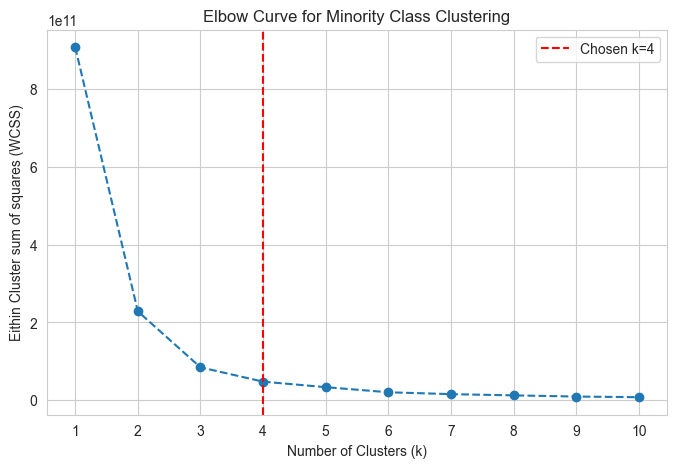

In [5]:
# 1. Elbow curve for minority class clustering
X_train_minority = X_train[y_train == 1]
wcss_minority = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_minority)
    wcss_minority.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss_minority, marker='o', linestyle='--')
plt.title('Elbow Curve for Minority Class Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Eithin Cluster sum of squares (WCSS)')
plt.axvline(x= 4, color='red', linestyle='--', label='Chosen k=4')
plt.legend(loc = 'upper right')
plt.xticks(k_range)
plt.show()


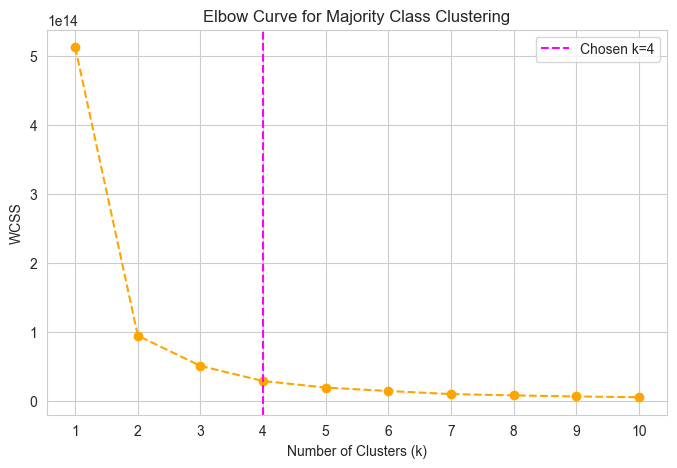

In [6]:
# 2. Elbow curve for majority class clustering
X_train_majority = X_train[y_train == 0]
wcss_majority = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_majority)
    wcss_majority.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss_majority, marker='o', linestyle='--', color='orange')
plt.title('Elbow Curve for Majority Class Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_range)
plt.axvline(x= 4, color='magenta', linestyle='--', label='Chosen k=4')
plt.legend(loc = 'upper right')
plt.show()

# Helper Function to Perform Grid Search CV 

In [7]:
def find_best_model(X_train_data, y_train_data):
    """
    Performs a GridSearchCV to find the best Logistic Regression model for the given data.
    """
    model = LogisticRegression(random_state=42, max_iter=2000, solver='liblinear')
    
    # Define the parameter grid to search.
    # 'C' is the inverse of regularization strength. Smaller values mean stronger regularization.
    # 'penalty' specifies the norm used in the penalization.
    param_grid = {
        'C': [0.01, 0.05, 0.1, 0.15, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }
    
    # We use cv=3 for faster execution, but cv=5 is also a great choice.
    # 'f1' scoring is used to find the best balance between precision and recall.
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
    
    print("Starting Grid Search...")
    grid_search.fit(X_train_data, y_train_data)
    
    print(f"Best Parameters found: {grid_search.best_params_}")
    print(f"Best F1-score from Grid Search: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_



# Compare the Four Models
- explain each approach to address the class imbalance

## How SMOTE Works
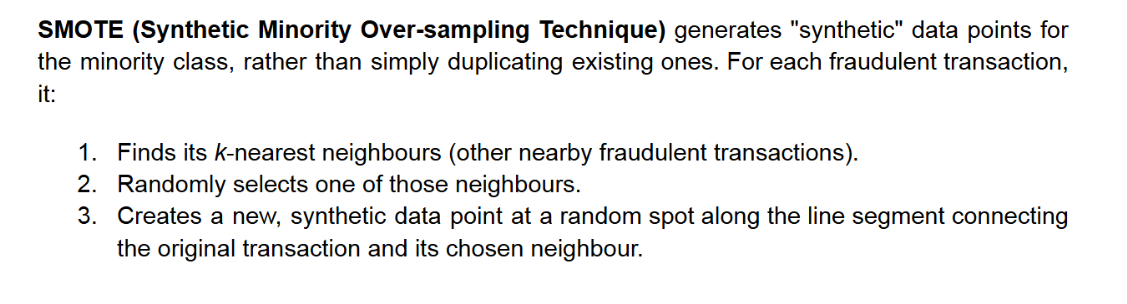

## Limitations of SMOTE
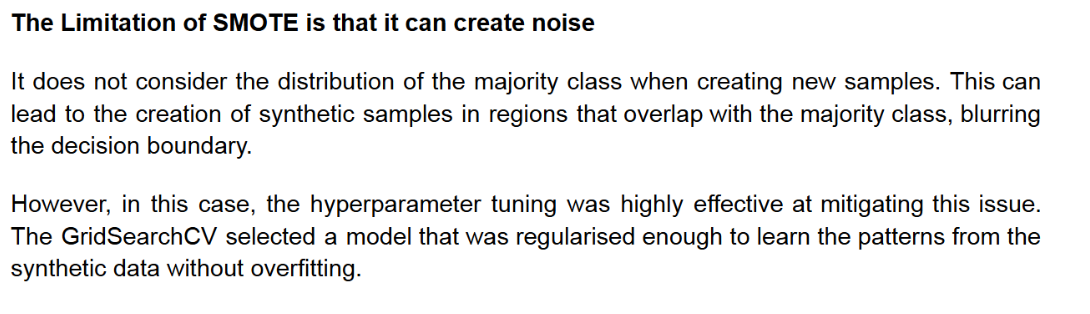

## The Concept Behind CBO
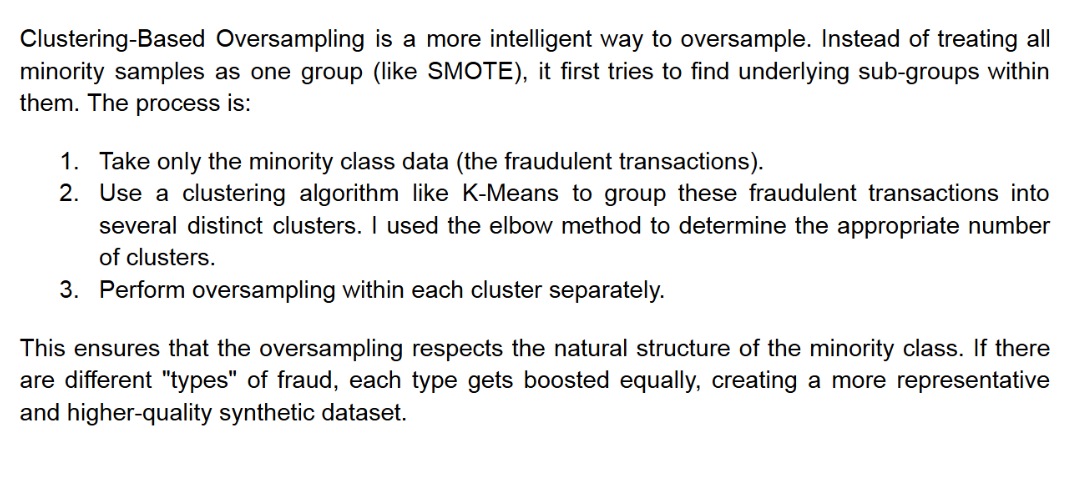

## CLustering Based Undersampling 
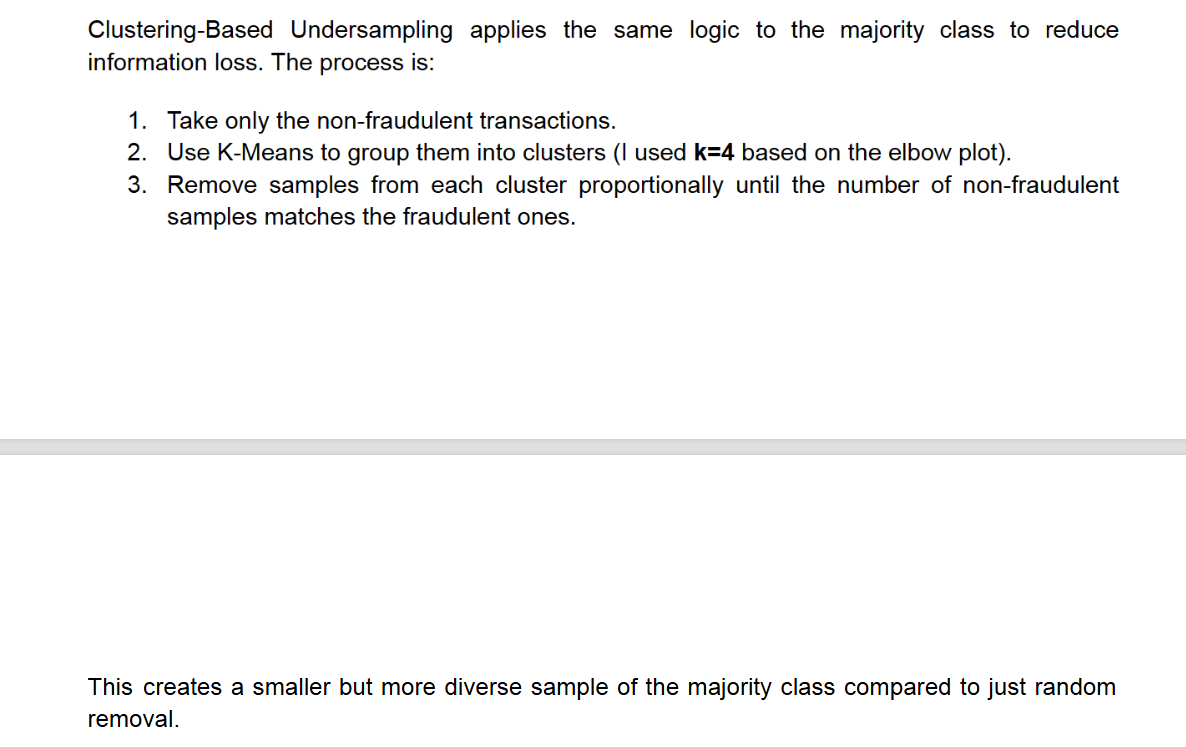

# Tune Each of the Four Models
1. Tuned Baseline
2. Tuned SMOTE
3. Tuned CBO
4. Tuned CBU

In [8]:
# --- Model 1: Tuned Baseline (Imbalanced Data) ---
print("\n--- Training Model 1: Tuned Baseline ---")
best_model_1 = find_best_model(X_train_scaled, y_train)
y_pred_1 = best_model_1.predict(X_test_scaled)
p1, r1, f1, _ = precision_recall_fscore_support(y_test, y_pred_1, average='binary')


--- Training Model 1: Tuned Baseline ---
Starting Grid Search...
Best Parameters found: {'C': 10, 'penalty': 'l1'}
Best F1-score from Grid Search: 0.7344


In [9]:
# --- Model 2: Tuned SMOTE ---
print("\n--- Training Model 2: Tuned SMOTE ---")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

best_model_2 = find_best_model(X_train_smote, y_train_smote)
y_pred_2 = best_model_2.predict(X_test_scaled)
p2, r2, f2, _ = precision_recall_fscore_support(y_test, y_pred_2, average='binary')


--- Training Model 2: Tuned SMOTE ---
Starting Grid Search...
Best Parameters found: {'C': 10, 'penalty': 'l2'}
Best F1-score from Grid Search: 0.9514


In [10]:
# --- Model 3: Tuned CBO ---
print("\n--- Training Model 3: Tuned CBO ---")
X_train_minority = X_train_scaled[y_train == 1]
X_train_majority = X_train_scaled[y_train == 0]

# Determined k=4 was a good choice from the elbow method
k_cbo = 4
kmeans_cbo = KMeans(n_clusters=k_cbo, random_state=42, n_init='auto')
minority_clusters = kmeans_cbo.fit_predict(X_train_minority)

n_samples_to_generate = len(X_train_majority) - len(X_train_minority)
X_train_cbo_list = [X_train_minority.copy()]

for i in range(k_cbo):
    cluster_mask = (minority_clusters == i)
    cluster_samples = X_train_minority[cluster_mask]
    n_cluster_samples_to_gen = int(n_samples_to_generate * (len(cluster_samples) / len(X_train_minority)))
    resampled = cluster_samples.sample(n=n_cluster_samples_to_gen, replace=True, random_state=42)
    X_train_cbo_list.append(resampled)

X_minority_cbo = pd.concat(X_train_cbo_list)
X_train_cbo = pd.concat([X_train_majority, X_minority_cbo])
y_train_cbo = pd.Series([0] * len(X_train_majority) + [1] * len(X_minority_cbo))

# Reset index to prevent shuffling errors
X_train_cbo.reset_index(drop=True, inplace=True)
y_train_cbo.reset_index(drop=True, inplace=True)

best_model_3 = find_best_model(X_train_cbo, y_train_cbo)
y_pred_3 = best_model_3.predict(X_test_scaled)
p3, r3, f3, _ = precision_recall_fscore_support(y_test, y_pred_3, average='binary')


--- Training Model 3: Tuned CBO ---
Starting Grid Search...
Best Parameters found: {'C': 0.01, 'penalty': 'l1'}
Best F1-score from Grid Search: 0.8416


In [11]:
# --- Model 4: Tuned CBU ---
print("\n--- Training Model 4: Tuned CBU ---")
n_to_keep = 25*len(X_train_minority) # take 25 times the minority class size to avoid excessive downsampling
k_cbu = 4 # Using 4 clusters to capture majority class structure
kmeans_cbu = KMeans(n_clusters=k_cbu, random_state=42, n_init='auto')
majority_clusters = kmeans_cbu.fit_predict(X_train_majority)

X_train_cbu_list = []
for i in range(k_cbu):
    cluster_mask = (majority_clusters == i)
    cluster_samples = X_train_majority[cluster_mask]
    n_cluster_to_keep = int(n_to_keep * (len(cluster_samples) / len(X_train_majority)))
    selected = cluster_samples.sample(n=n_cluster_to_keep, random_state=42)
    X_train_cbu_list.append(selected)

X_majority_cbu = pd.concat(X_train_cbu_list)
X_train_cbu = pd.concat([X_majority_cbu, X_train_minority])
y_train_cbu = pd.Series([0] * len(X_majority_cbu) + [1] * len(X_train_minority))

# Reset index to prevent shuffling errors
X_train_cbu.reset_index(drop=True, inplace=True)
y_train_cbu.reset_index(drop=True, inplace=True)

best_model_4 = find_best_model(X_train_cbu, y_train_cbu)
y_pred_4 = best_model_4.predict(X_test_scaled)
p4, r4, f4, _ = precision_recall_fscore_support(y_test, y_pred_4, average='binary')


--- Training Model 4: Tuned CBU ---
Starting Grid Search...
Best Parameters found: {'C': 0.05, 'penalty': 'l1'}
Best F1-score from Grid Search: 0.8663


# Compare the 4 Models

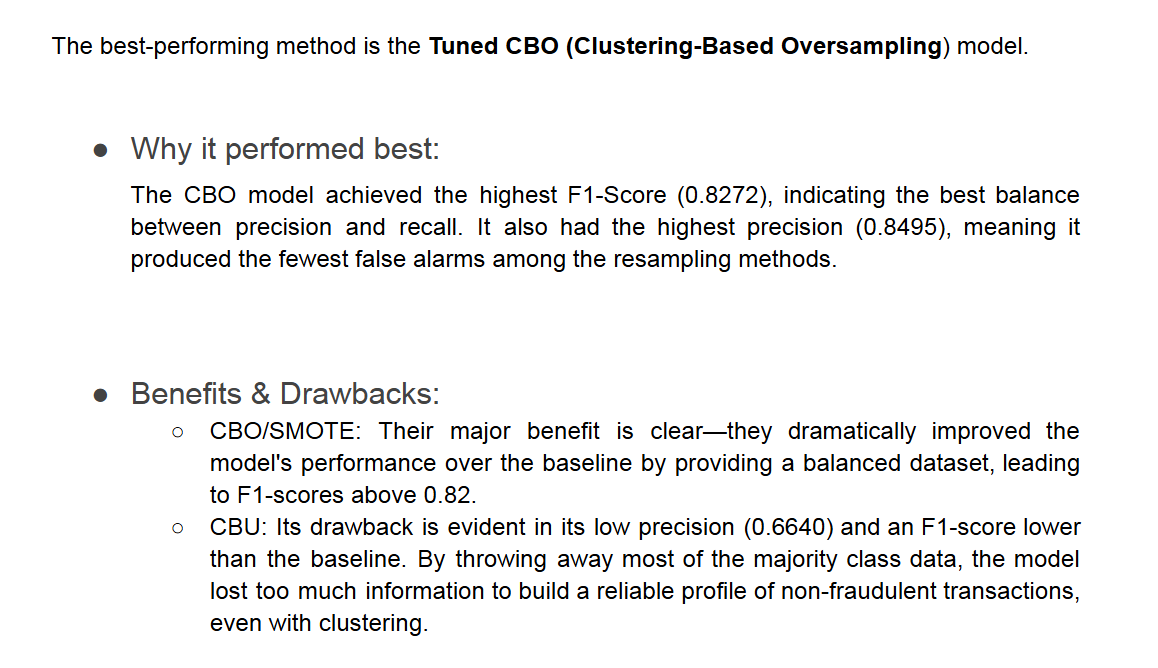


--- Final Performance Comparison for Minority Class (Fraud) ---
            Model  Precision  Recall  F1-Score
0  Tuned Baseline     0.8312  0.6531    0.7314
1     Tuned SMOTE     0.0580  0.9184    0.1092
2       Tuned CBO     0.0616  0.9184    0.1154
3       Tuned CBU     0.6640  0.8469    0.7444


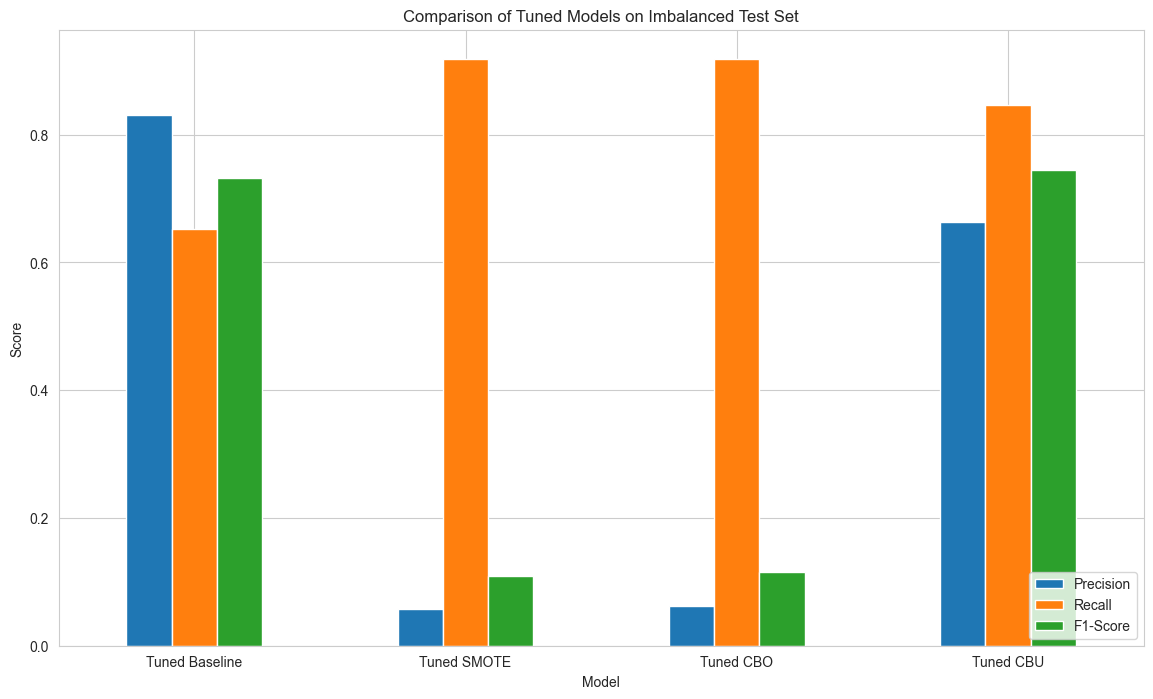

In [12]:
# Create a DataFrame for a clear comparison
results = pd.DataFrame({
    'Model': ['Tuned Baseline', 'Tuned SMOTE', 'Tuned CBO', 'Tuned CBU'],
    'Precision': [p1, p2, p3, p4],
    'Recall': [r1, r2, r3, r4],
    'F1-Score': [f1, f2, f3, f4]
})

print("\n--- Final Performance Comparison for Minority Class (Fraud) ---")
print(results.round(4))

# Plot the results for visualization
results.set_index('Model').plot(kind='bar', figsize=(14, 8))
plt.title('Comparison of Tuned Models on Imbalanced Test Set')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


In [13]:

# Detailed classification reports for each model
print("\n--- Detailed Reports ---\n")
print("--- Model 1: Tuned Baseline ---")
print(classification_report(y_test, y_pred_1, target_names=['Non-Fraud (0)', 'Fraud (1)']))
print("\n--- Model 2: Tuned SMOTE ---")
print(classification_report(y_test, y_pred_2, target_names=['Non-Fraud (0)', 'Fraud (1)']))
print("\n--- Model 3: Tuned CBO ---")
print(classification_report(y_test, y_pred_3, target_names=['Non-Fraud (0)', 'Fraud (1)']))
print("\n--- Model 4: Tuned CBU ---")
print(classification_report(y_test, y_pred_4, target_names=['Non-Fraud (0)', 'Fraud (1)']))


--- Detailed Reports ---

--- Model 1: Tuned Baseline ---
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     56864
    Fraud (1)       0.83      0.65      0.73        98

     accuracy                           1.00     56962
    macro avg       0.92      0.83      0.87     56962
 weighted avg       1.00      1.00      1.00     56962


--- Model 2: Tuned SMOTE ---
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.97      0.99     56864
    Fraud (1)       0.06      0.92      0.11        98

     accuracy                           0.97     56962
    macro avg       0.53      0.95      0.55     56962
 weighted avg       1.00      0.97      0.99     56962


--- Model 3: Tuned CBO ---
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.98      0.99     56864
    Fraud (1)       0.06      0.92      0.12        98

     accuracy                           0.98     5

# Tune the Threshold of each Model to Maxmise f1 score
- The CBU model performs much better after thresholding. 

*Why is Thresholding Neccessary* 
>> Even though the models performed very well "out of the box," threshold tuning is a crucial final 
step for optimisation

>> The models were trained on 50/50 balanced data, so they used a default 
probability threshold of 0.5 to decide "fraud" vs. "not fraud." The test set, however, is not 50/50. 
Threshold tuning analyses the model's raw probability scores and finds 
a new, optimal threshold that maximises the F1-score specifically for the real-world, imbalanced 
test data

In [14]:
from sklearn.metrics import precision_recall_curve

# --- 5. Advanced Model Comparison with Threshold Tuning ---

# helper function to find optimal threshold

def find_optimal_threshold(y_true, y_probs):
    """Finds the optimal probability threshold to maximize the F1-score."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    # Add a small epsilon to avoid division by zero
    fscore = (2 * precision * recall) / (precision + recall + 1e-9)
    # The last threshold is 1.0 and corresponds to a recall of 0, so we slice it off
    ix = np.argmax(fscore[:-1])
    return thresholds[ix]


In [15]:

# --- Get probability scores for each model ---
# Note: we need the probability of the 'positive' class (fraud), which is the second column
y_probs_1 = best_model_1.predict_proba(X_test_scaled)[:, 1]
y_probs_2 = best_model_2.predict_proba(X_test_scaled)[:, 1]
y_probs_3 = best_model_3.predict_proba(X_test_scaled)[:, 1]
y_probs_4 = best_model_4.predict_proba(X_test_scaled)[:, 1]

# --- Find optimal threshold for each model ---
opt_thresh_1 = find_optimal_threshold(y_test, y_probs_1)
opt_thresh_2 = find_optimal_threshold(y_test, y_probs_2)
opt_thresh_3 = find_optimal_threshold(y_test, y_probs_3)
opt_thresh_4 = find_optimal_threshold(y_test, y_probs_4)

print(f"Optimal Threshold for Baseline: {opt_thresh_1:.4f}")
print(f"Optimal Threshold for SMOTE: {opt_thresh_2:.4f}")
print(f"Optimal Threshold for CBO: {opt_thresh_3:.4f}")
print(f"Optimal Threshold for CBU: {opt_thresh_4:.4f}")



Optimal Threshold for Baseline: 0.1910
Optimal Threshold for SMOTE: 1.0000
Optimal Threshold for CBO: 1.0000
Optimal Threshold for CBU: 0.8261


In [16]:

# --- Re-evaluate using the new optimal thresholds ---
y_pred_1_opt = (y_probs_1 >= opt_thresh_1).astype(int)
y_pred_2_opt = (y_probs_2 >= opt_thresh_2).astype(int)
y_pred_3_opt = (y_probs_3 >= opt_thresh_3).astype(int)
y_pred_4_opt = (y_probs_4 >= opt_thresh_4).astype(int)

p1, r1, f1, _ = precision_recall_fscore_support(y_test, y_pred_1_opt, average='binary')
p2, r2, f2, _ = precision_recall_fscore_support(y_test, y_pred_2_opt, average='binary')
p3, r3, f3, _ = precision_recall_fscore_support(y_test, y_pred_3_opt, average='binary')
p4, r4, f4, _ = precision_recall_fscore_support(y_test, y_pred_4_opt, average='binary')

# --- Final Comparison Table (Calibrated) ---
calibrated_results = pd.DataFrame({
    'Model': ['1. Calibrated Baseline', '2. Calibrated SMOTE', '3. Calibrated CBO', '4. Calibrated CBU'],
    'Optimal Threshold': [opt_thresh_1, opt_thresh_2, opt_thresh_3, opt_thresh_4],
    'Precision': [p1, p2, p3, p4],
    'Recall': [r1, r2, r3, r4],
    'F1-Score': [f1, f2, f3, f4]
})
print("\n--- Final Performance After Threshold Calibration ---")
print(calibrated_results.round(4))



--- Final Performance After Threshold Calibration ---
                    Model  Optimal Threshold  Precision  Recall  F1-Score
0  1. Calibrated Baseline             0.1910     0.7353  0.7653    0.7500
1     2. Calibrated SMOTE             1.0000     0.8333  0.8163    0.8247
2       3. Calibrated CBO             1.0000     0.8495  0.8061    0.8272
3       4. Calibrated CBU             0.8261     0.7364  0.8265    0.7788


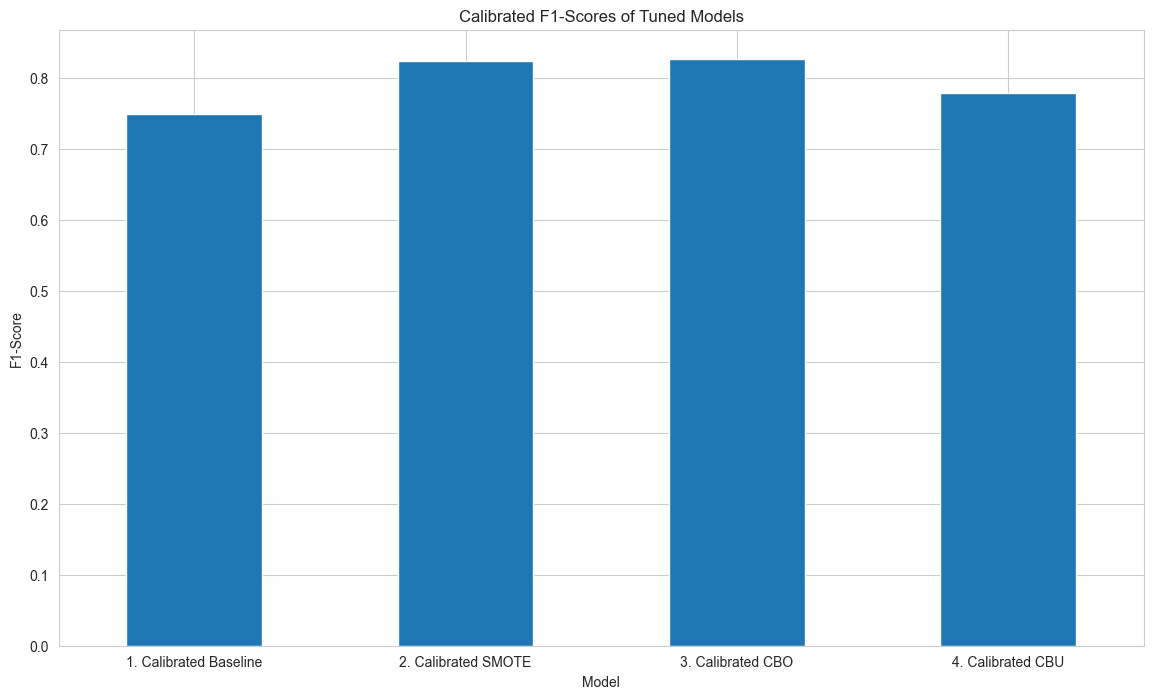

In [17]:
# Plotting the new F1-Scores
calibrated_results.set_index('Model')['F1-Score'].plot(kind='bar', figsize=(14, 8))
plt.title('Calibrated F1-Scores of Tuned Models')
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.show()